In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
matplotlib.use('Agg')

# 10臂赌博机测试平台

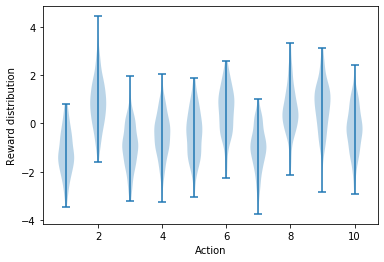

In [2]:
plt.violinplot(dataset=np.random.randn(200, 10) + np.random.randn(10))
plt.xlabel("Action")
plt.ylabel("Reward distribution")
plt.savefig('Action_Reward distribution')

# Bandit 类

In [3]:
class Bandit:
    
    def __init__(self, k_arm=10, epsilon=0., initial=0., step_size=0.1, sample_averages=False, UCB_param=None,
                 gradient=False, gradient_baseline=False, true_reward=0.):
        
        # k_arm：k-臂赌博机，这里k=10
        self.k = k_arm
        # step_size：更新估计时的固定步长（只有在固定步长时才使用）
        self.step_size = step_size
        # sample_averages：若为真，则代表使用采样平均法去更新估计，而非使用固定的步长
        self.sample_averages = sample_averages
        # indices：生成k的排列，用与随机选择action
        self.indices = np.arange(self.k)
        # time：目标为第n次循环后得到的收获最大
        self.time = 0
        # UCB_param：若UCB_param不是None值，则采用UCB算法选择action
        self.UCB_param = UCB_param
        # gradient：若gradient为真，则使用梯度赌博机算法
        self.gradient = gradient
        # gradient_baseline：若为真，则使用平均收获作为基准项
        self.gradient_baseline = gradient_baseline
        # average_reward：平均收获
        self.average_reward = 0
        # true_reward：初始化真实收益使用的
        self.true_reward = true_reward
        # epsilon：用与epsilon-greedy算法
        self.epsilon = epsilon
        # initial：初始化时，对每个行为价值进行估计
        self.initial = initial

    # reset函数：#对每个 K-臂赌博机 进行重置
    def reset(self):
        # 初始化每个行为的真实价值
        self.q_true = np.random.randn(self.k) + self.true_reward
        # 对每个行为进行初始估计
        self.q_estimation = np.zeros(self.k) + self.initial
        # 对每个行为进行计数（可能需要用到采样平均算法）
        self.action_count = np.zeros(self.k)
        # 最好的行为就是真实价值最大的行为
        self.best_action = np.argmax(self.q_true)
        #重置训练步数
        self.time = 0

    # act函数：根据估计，选择一个合适的action返回
    def act(self):
        # 如果随机值小于epsilon，则随机（平均概率）在行为列表中选择行为 
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.indices)
        # 使用UCB算法选择行为
        if self.UCB_param is not None:
            UCB_estimation = self.q_estimation + \
                self.UCB_param * np.sqrt(np.log(self.time + 1) / (self.action_count + 1e-5))
            q_best = np.max(UCB_estimation)
            return np.random.choice(np.where(UCB_estimation == q_best)[0])
        # 使用梯度方式选择行为
        if self.gradient:
            exp_est = np.exp(self.q_estimation)
            self.action_prob = exp_est / np.sum(exp_est)
            return np.random.choice(self.indices, p=self.action_prob)
        # 以上都不满足，则选择估计价值最大的行为（若有多个相同最大的估计值，则在里面随机选择）
        q_best = np.max(self.q_estimation)
        return np.random.choice(np.where(self.q_estimation == q_best)[0])

    # step函数：生成真实收益（从以由一C个均值为q*(At)，方差为1的标准正态分布中生成）执行action，并且返回真实收益
    def step(self, action):
        # 生成该行为的真实收益
        reward = np.random.randn() + self.q_true[action]
        # 更新计数
        self.time += 1
        self.action_count[action] += 1
        self.average_reward += (reward - self.average_reward) / self.time
        
        # 如果使用了采样平均策略
        if self.sample_averages:
            self.q_estimation[action] += (reward - self.q_estimation[action]) / self.action_count[action]
            
       # 如果采用梯度策略
        elif self.gradient:
            one_hot = np.zeros(self.k)
            one_hot[action] = 1
            if self.gradient_baseline:
                baseline = self.average_reward
            else:
                baseline = 0
            self.q_estimation += self.step_size * (reward - baseline) * (one_hot - self.action_prob)
        
        # 在固定步长的情况更新估计
        else:
            self.q_estimation[action] += self.step_size * (reward - self.q_estimation[action])
        return reward

# simulate函数

In [ ]:
def simulate(runs, time, bandits):
    #初始化reward与best_action的计数器
    rewards = np.zeros((len(bandits), runs, time))
    best_action_counts = np.zeros(rewards.shape)
    
    #首先对bandit进行遍历
    for i, bandit in enumerate(bandits):
        #对2000个不同赌博机问题进行遍历，并画进度条
        for r in trange(runs):
            bandit.reset()
            #对训练步数进行遍历
            for t in range(time):
                action = bandit.act()
                reward = bandit.step(action)
                rewards[i, r, t] = reward
                if action == bandit.best_action:
                    best_action_counts[i, r, t] = 1
    mean_best_action_counts = best_action_counts.mean(axis=1)
    mean_rewards = rewards.mean(axis=1)
    return mean_best_action_counts, mean_rewards

# ε-贪心方法

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:31<00:00, 63.77it/s]


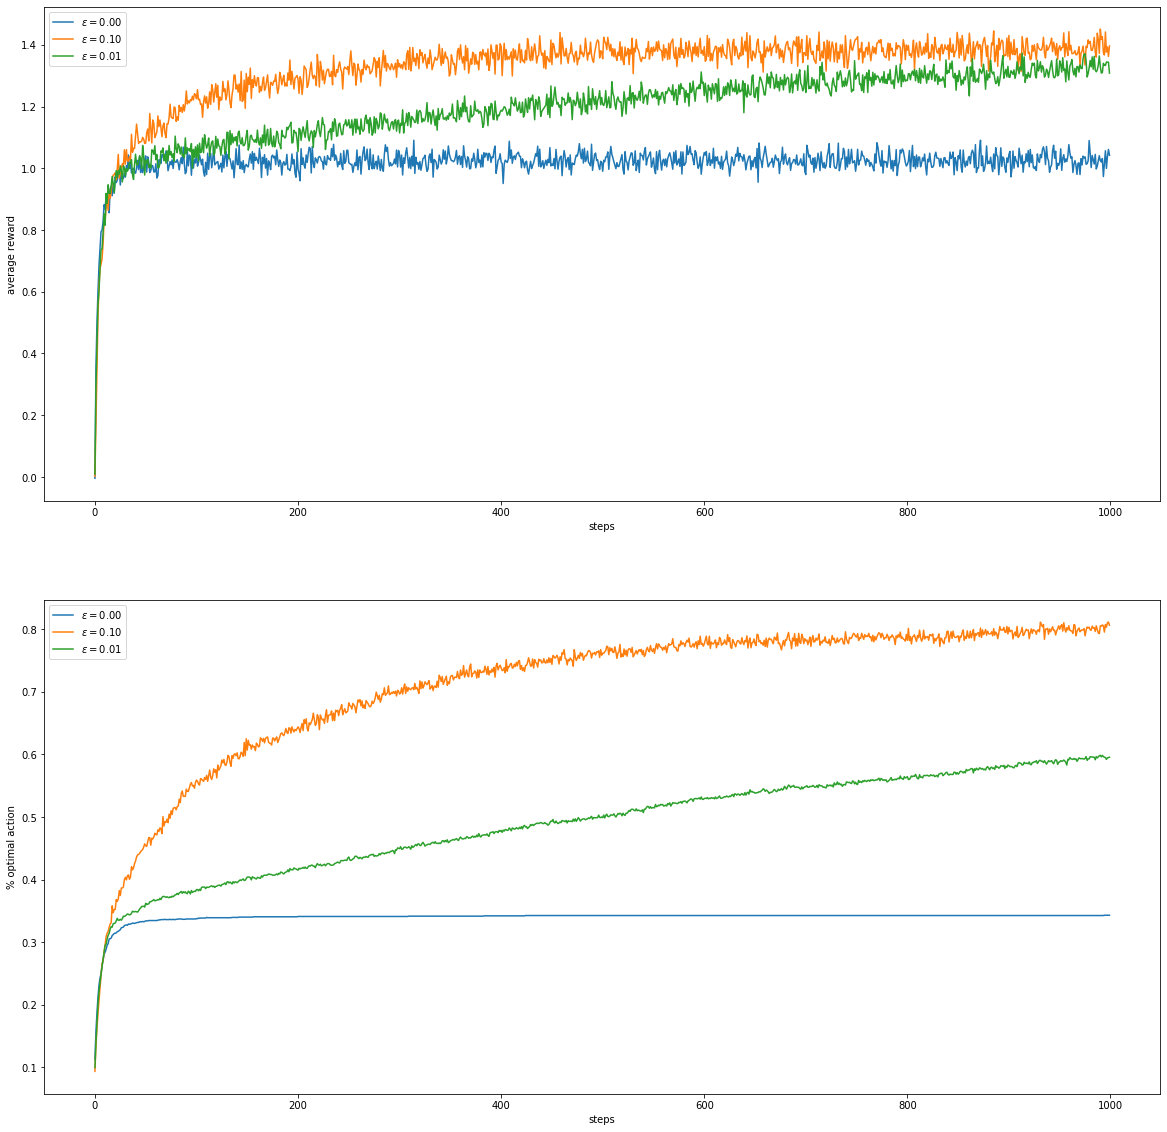

In [5]:
runs=2000
time=1000

#分别使用3个不同ε
epsilons = [0, 0.1, 0.01]
bandits = [Bandit(epsilon=eps, sample_averages=True) for eps in epsilons]

#计算平均最优行为数量 和 平均收益
best_action_counts, rewards = simulate(runs, time, bandits)

plt.figure(figsize=(20, 20))
plt.subplot(2, 1, 1)
for eps, rewards in zip(epsilons, rewards):
    plt.plot(rewards, label='$\epsilon = %.02f$' % (eps))
plt.xlabel('steps')
plt.ylabel('average reward')
plt.legend()

plt.subplot(2, 1, 2)
for eps, counts in zip(epsilons, best_action_counts):
    plt.plot(counts, label='$\epsilon = %.02f$' % (eps))
plt.xlabel('steps')
plt.ylabel('% optimal action')
plt.legend()

plt.savefig('figure_2_2.png')

# 乐观初始值作用

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:30<00:00, 65.41it/s]


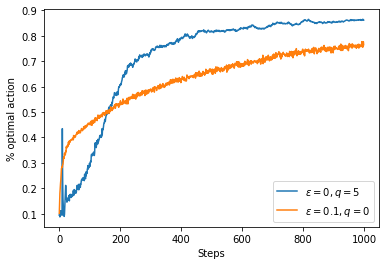

In [6]:
runs = 2000
time = 1000

bandits = []
# 乐观初始化，贪心
bandits.append(Bandit(epsilon=0, initial=5, step_size = 0.1))
# 一般初始化，ε-贪心
bandits.append(Bandit(epsilon=0.1, initial=0, step_size = 0.1))

# 计算平均最优动作
best_action_counts, _ = simulate(runs, time, bandits)

plt.plot(best_action_counts[0], label='$\epsilon = 0, q = 5$')
plt.plot(best_action_counts[1], label='$\epsilon = 0.1, q = 0$')
plt.xlabel('Steps')
plt.ylabel('% optimal action')
plt.legend()

plt.savefig('figure_2_3.png')

# 基于置信度上界

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:31<00:00, 62.76it/s]


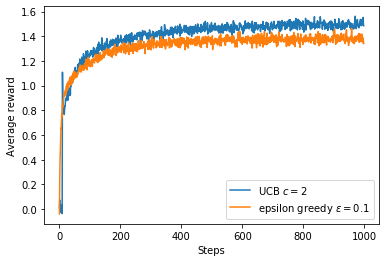

In [8]:
runs = 2000
time = 1000

bandits = []
bandits.append(Bandit(epsilon=0, UCB_param=2, sample_averages=True))
bandits.append(Bandit(epsilon=0.1, sample_averages=True))

_, average_rewards = simulate(runs, time, bandits)

plt.plot(average_rewards[0], label='UCB $c = 2$')
plt.plot(average_rewards[1], label='epsilon greedy $\epsilon = 0.1$')
plt.xlabel('Steps')
plt.ylabel('Average reward')
plt.legend()

plt.savefig('figure_2_4.png')

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:26<00:00, 23.10it/s]


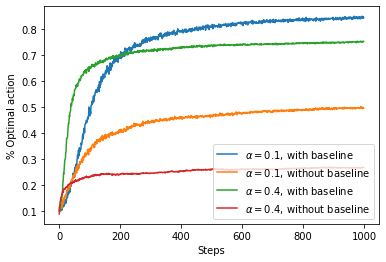

In [9]:
bandits = []
bandits.append(Bandit(gradient=True, step_size=0.1, gradient_baseline=True, true_reward=4))
bandits.append(Bandit(gradient=True, step_size=0.1, gradient_baseline=False, true_reward=4))
bandits.append(Bandit(gradient=True, step_size=0.4, gradient_baseline=True, true_reward=4))
bandits.append(Bandit(gradient=True, step_size=0.4, gradient_baseline=False, true_reward=4))
best_action_counts, _ = simulate(runs, time, bandits)

labels = [r'$\alpha = 0.1$, with baseline',
            r'$\alpha = 0.1$, without baseline',
            r'$\alpha = 0.4$, with baseline',
            r'$\alpha = 0.4$, without baseline']

for i in range(len(bandits)):
    plt.plot(best_action_counts[i], label=labels[i])
plt.xlabel('Steps')
plt.ylabel('% Optimal action')
plt.legend()

plt.savefig('figure_2_5.png')

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:31<00:00, 62.69it/s]


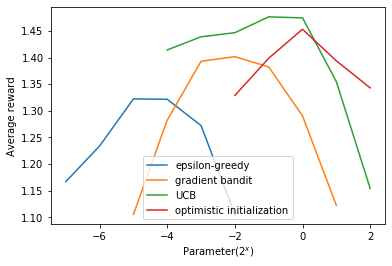

In [12]:
labels = ['epsilon-greedy', 'gradient bandit',
          'UCB', 'optimistic initialization']
generators = [lambda epsilon: Bandit(epsilon=epsilon, sample_averages=True),
              lambda alpha: Bandit(gradient=True, step_size=alpha, gradient_baseline=True),
              lambda coef: Bandit(epsilon=0, UCB_param=coef, sample_averages=True),
              lambda initial: Bandit(epsilon=0, initial=initial, step_size=0.1)]
parameters = [np.arange(-7, -1, dtype=np.float),
              np.arange(-5, 2, dtype=np.float),
              np.arange(-4, 3, dtype=np.float),
              np.arange(-2, 3, dtype=np.float)]

bandits = []
for generator, parameter in zip(generators, parameters):
    for param in parameter:
        bandits.append(generator(pow(2, param)))

_, average_rewards = simulate(runs, time, bandits)
rewards = np.mean(average_rewards, axis=1)

i = 0
for label, parameter in zip(labels, parameters):
    l = len(parameter)
    plt.plot(parameter, rewards[i:i+l], label=label)
    i += l
plt.xlabel('Parameter($2^x$)')
plt.ylabel('Average reward')
plt.legend()

plt.savefig('figure_2_6.png')